# Hamiltonian Time Evolution

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

In [61]:
def pauli_operators(n_qubits):
    pauli_strings=["I","X","Y","Z"]
    pauli_product_strings=list(map(lambda x : "".join(x),list(itertools.product(*[pauli_strings for i in range(n_qubits)]))))
    return pauli_product_strings
    

def sigma_real_terms(n_qubits):
    """
    Get all possible pauli operators with an odd number of Y gates for n_qubit qubits 
    
    Input:
        n_qubits (int) : number of qubits 

    Returns:
        sigmas (list<WeightedPauliOperator>) : List of pauli operators with an odd number of Y

    """ 
    pauli_strings=["I","X","Y","Z"]
    pauli_product_strings=list(map(lambda x : "".join(x),list(itertools.product(*[pauli_strings for i in range(n_qubits)]))))

    ## Extract out pauli terms of odd number of Y 
    paulis=[]
    for string in pauli_product_strings:
        if string.count("Y")%2==0:
            paulis.append(Pauli.from_label(string))

    sigmas=[]
    for pauli in paulis:
        sigma=[(1.0,pauli)]
        sigmas.append(WeightedPauliOperator(sigma))

    return sigmas

H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits
## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_real_terms(n_qubits)

## Construct S
S_pauli_terms=S_terms(sigmas)

# pauli_set=get_intersection_pauli_terms(H_qubit,beta_pauli_terms,S_pauli_terms)

# commuting_sets=get_commuting_sets(sorted(pauli_set))
# for p in commuting_sets:
#     print(p, commuting_sets[p],p[::-1])
    


In [62]:
def weighted_pauli_matrix(W):
    pauli_terms=get_pauli_terms(W)
    matrix=reduce(lambda x,y: x+y,[pauli_terms[term]*get_pauli_matrix(term) for term in pauli_terms])
    return matrix



def run_time_evolution_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
    n_shots=10000 ## Set to allowed number of shots at IBMQ
 
    ## Get commuting set 
    commuting_sets=H.pauli_partitions

    ## Zero initialize 
    results_dict={}
    A_set=[]
    Energies=np.zeros(num_iterations)

    ## for each time step, run circuit
    for t in tqdm(range(num_iterations)):
        expectation_values={}
        if backend=='statevector_simulator':
            psi,counts=run_circuit_statevector_counts(n_qubits,A_set,delta_time,initialization="uniform")
            
            if t>0:
                for state in counts:
                    if t==1:
                        results_dict[state[::-1]] = [counts[state]]
                    else:
                        results_dict[state[::-1]].append(counts[state])
                    
            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value
                    
        ## qasm_simulator
        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=n_shots,initialization="uniform")

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        for key in H_pauli:
            Energies[t]+=H_pauli[key]*expectation_values[key]

        A_set.append(H.weighted_pauli)

    return Energies,results_dict

In [63]:
#####################################       
# Prepare and run the evolution circuit
#####################################       

# num_iterations=3
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="uniform"

Energy_table=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies,results_dict=run_time_evolution_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


In [64]:
# print(results_dict)
print(sv_energies)

[1.70943224 1.74505745 1.78030497 1.81439723 1.84660073 1.87625517
 1.90279849 1.92578624 1.94490433 1.9599745  1.97095228 1.97791799
 1.98106132 1.98066089 1.97706015 1.97064146 1.96180003 1.95091955
 1.93835117 1.92439694 1.90929903 1.89323493 1.87631899 1.85860973
 1.84012234 1.82084497 1.80075761 1.77985177 1.75814939 1.73571938
 1.71269032 1.68925831 1.66568903 1.64231394 1.61952051 1.59773718
 1.57741394 1.55899994 1.54291957 1.5295487  1.51919293 1.51206915
 1.50829202 1.50786633 1.51068576 1.51653841 1.52511874 1.53604513
 1.54888205 1.56316535]


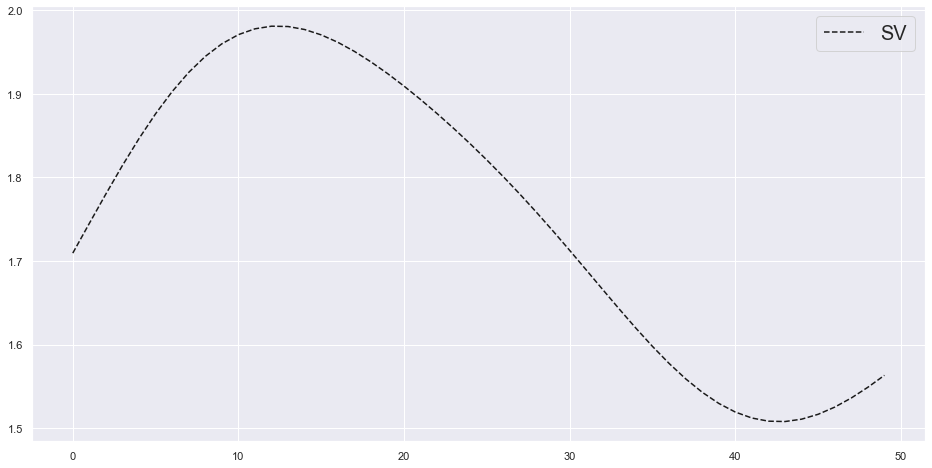

In [65]:
time=[t for t in range(num_iterations)]
plt.plot(sv_energies,'k--',label="SV")
# plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
# plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
# plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
# plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

In [66]:
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian")
H_qubit = GrayCodeHamiltonian(H)
my_pauli = H_qubit.weighted_pauli
print(my_pauli.print_details())


# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 21
# Arbitrary simulation time




backend = Aer.get_backend('statevector_simulator')

states_gc = ['00', '10', '11', '01']
results_dict_gc = {x : np.zeros(max_trotter_steps) for x in states_gc}

trace_dists_gc = np.zeros(max_trotter_steps)

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps + 1)):
    # Prepare and run the evolution circuit
    q = QuantumRegister(H_qubit.N_qubits)
    circuit = QuantumCircuit(q)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=delta_time*n_trotter_steps, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
      # Get and process results
    job = execute(circuit, backend)
    statevector = job.result().get_statevector(circuit)
    results = job.result().get_counts(circuit)
#     print(results)
#     if n_trotter_steps == max_trotter_steps:
#     print("state vector")
#     print(statevector)
        
#     trace_dists_gc[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_gc), qt.Qobj(statevector))
    
    for state in results_dict_gc.keys():
        # Need to reverse the state we put the counts in because our labels are
        # normally ordered, and Qiskit gives them to us backwards
        results_dict_gc[state[::-1]][n_trotter_steps-1] = results[state]

 33%|███▎      | 7/21 [00:00<00:00, 61.85it/s]

II	(7.7658547225+0j)
IZ	(-7.9841452775+0j)
ZI	(-1.8591452774999997+0j)
ZZ	(1.6408547225000003+0j)
IX	(-2.1433035249352805+0j)
ZX	(-2.1433035249352805+0j)
XI	(-3.913118960624632+0j)
XZ	(3.913118960624632+0j)



100%|██████████| 21/21 [00:00<00:00, 28.57it/s]


In [67]:
print(results_dict_gc)

{'00': array([0.24832636, 0.24773716, 0.24835942, 0.25038752, 0.25406663,
       0.25967075, 0.26747705, 0.27773833, 0.29065576, 0.30635375,
       0.32485906, 0.34608556, 0.3698261 , 0.39575202, 0.42342068,
       0.45229059, 0.48174328, 0.51111057, 0.53970554, 0.56685516,
       0.59193248]), '10': array([0.25167364, 0.25664588, 0.26460656, 0.27499929, 0.28705772,
       0.29985613, 0.31237054, 0.32354657, 0.3323692 , 0.33792988,
       0.3394865 , 0.33651211, 0.32872933, 0.31612817, 0.29896623,
       0.27775141, 0.25320859, 0.22623264, 0.19783114, 0.16906091,
       0.14096284]), '11': array([0.25      , 0.24561696, 0.23703402, 0.2246132 , 0.20887565,
       0.19047312, 0.17015241, 0.1487151 , 0.12697504, 0.10571637,
       0.08565444, 0.06740233, 0.05144457, 0.03811981, 0.0276131 ,
       0.01995801, 0.01504813, 0.01265679, 0.01246332, 0.01408393,
       0.01710468]), '01': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25

In [68]:
print(results_dict)

{'00': [0.248326363453667, 0.247737164208974, 0.248359416589939, 0.250387515611913, 0.254066627949964, 0.25967075146551, 0.26747704721937, 0.277738330859783, 0.290655759413109, 0.306353754078502, 0.324859059076018, 0.34608556058857, 0.369826097590859, 0.395752015294997, 0.423420675762176, 0.452290586541666, 0.481743275879123, 0.511110569496763, 0.539705542504109, 0.566855157527211, 0.59193247519439, 0.614386344600354, 0.633766647935853, 0.64974347359147, 0.662119004829924, 0.670831407776986, 0.675950548330143, 0.677665924500204, 0.676267729784067, 0.672122427472965, 0.665644582934724, 0.657266945298234, 0.64741087465735, 0.636459168748893, 0.624733157200287, 0.612475615123375, 0.599840623439253, 0.586891000817284, 0.573603386932187, 0.559880507297416, 0.54556963491193, 0.530485819612899, 0.514438113624919, 0.497256805420886, 0.478819598871295, 0.459074746027087, 0.438059354716262, 0.415911431442735, 0.392874661965285], '10': [0.251673636546333, 0.256645877152419, 0.264606563998354, 0.2

In [69]:
for state in results_dict:
    for i in range(len(results_dict[state])):
        if(abs(results_dict[state][i]-results_dict_gc[state][i])>1e-8):
#         if True:
            print(state,i,results_dict[state][i],results_dict_gc[state][i])

IndexError: index 21 is out of bounds for axis 0 with size 21

In [78]:
def beta_terms(evolution_op,sigmas):
    """
    Compute beta={H,sigma}

    Input:
        H (hamiltonian.EncodingHamiltonian) : Qubit Hamiltonian
        sigmas (list<WeightedPauliOperator>) : List of pauli operators with an odd number of Y
            
    Returns:

        b (dictionary) : b operator expressed as dictionary of {label:coef}, each label is a pauli string.
    """

    beta_pauli_terms=[]
    
    for sigma in sigmas:
        product=(evolution_op.__mul__(sigma)+sigma.__mul__(evolution_op))
        product.chop(1e-5)
        terms=get_pauli_terms(product)
        beta_pauli_terms.append(terms)
    return beta_pauli_terms



def update_evolution_operators(evolution_operators,delta_time,sigmas,S_pauli_terms,expectation_values,threshold=1e-10,verbose=False):
    """
    Solve 2Sa=b for a
    """   
    
    n_qubits=sigmas[0].num_qubits
    
    # zero init evolution operator
    evolution_op = WeightedPauliOperator([(0.0,Pauli.from_label("I"*n_qubits))])
   
    ## Merge all operators into single term 
    for op in evolution_operators:
        evolution_op+=op

    ## compute b
    num_sigmas=len(sigmas)
    b_pauli_terms=beta_terms(evolution_op,sigmas)
    
    b=np.zeros(num_sigmas)
    for sigma_idx in range(num_sigmas):
        bI=b_pauli_terms[sigma_idx]
#         print(bI)
        for term in bI:
            b[sigma_idx]+=bI[term]*expectation_values[term]

    
    ## Comput S
    Smatrix=np.asmatrix(np.zeros((num_sigmas,num_sigmas)))
    for i in range(num_sigmas):
        for j in range(num_sigmas):
            Sij=S_pauli_terms[(i,j)]
            for term in Sij:
                #(S+S^T) gives rise to factor of 2
                Smatrix[i,j]+=2*Sij[term]*expectation_values[term] 

    ## Solve for a in (S+S^T)a=b
    a,_,_,_=lstsq(Smatrix,b,cond=threshold)
    if verbose==True:
        print("Smatrix")
        print(Smatrix)
        print("b\n",b)
        print("a\n",a)
    
    ## Construct A from a
    identity_string="I"*n_qubits

    ##Null initialize A with 0.0*Identity. 
    B=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
    for i in range((len(sigmas))):
        B+=a[i]*sigmas[i]

    ## Add new B to evolution operator
    evolution_op+=B
    evolution_operators=[evolution_op]
    
    ################################################################################
    if verbose==True:       
        print("t=",t)
        print("-----------------------------------------")

        print("wavefunction\n",wavefunction)        
        print("\nB operator")
        print(B.print_details())
        
        B_pauli_terms=get_pauli_terms(B)
        Bmatrix=reduce(lambda x,y: x+y,[B_pauli_terms[term]*get_pauli_matrix(term) for term in B_pauli_terms])
        print(Bmatrix)
        print("-----------------------------------------")
    
    return evolution_operators

def initialize_circuit(q,c,initial_state="zeros",no_classical=False):
    """
    Initialize circuit.  
    
    input:
        q (qiskit.circuit.quantumregister.QuantumRegister) : qubits
        initial_state(str or np.array) : initial state of circuit
            "zeros" (str,default) : starting state is qubit state with all qubits in zero state
            "uniform" (str) : Uniform superposition of all qubit states 
             array(np.array) : normalized array of len(2**n_qubits)
    returns
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : initialized quantum circuit
    """    
    if initial_state is None:
        initial_state="zeros"
        
    if isinstance(initial_state, str):
        if not (initial_state=="zeros" or initial_state=="uniform"):
            sys.exit(f"{initial_state} not currently valid option")
        if no_classical:
            circuit = QuantumCircuit(q)
        else:
            circuit = QuantumCircuit(q,c)

        if initial_state=="uniform":
            circuit.h(q)
    else:
        circuit = QuantumCircuit(q,c)
        circuit.initialize(initial_state,q)
    return circuit

def run_circuit_statevector_counts(n_qubits,A_set,time,initialization=None):
        ## Initalize circuit
#         print("qubits ", n_qubits)
        q = QuantumRegister(n_qubits)
        c = ClassicalRegister(n_qubits)
        
        circuit=initialize_circuit(q,c,initial_state=initialization,no_classical=True)
        
        ## If A_set not t, then evolve cirucit using previously computed A matrices stored in A_set
        if len(A_set)>0:
            circuit=append_evolution_circuit(q,A_set,time,circuit)

        ## Execute circuit
        backend=Aer.get_backend("statevector_simulator")
        job = execute(circuit,backend)
  
        return job.result().get_statevector(circuit),job.result().get_counts(circuit)        

    

    
def run_time_evolution_merged_statevector(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
    n_shots=10000 ## Set to allowed number of shots at IBMQ
 
    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=sigma_real_terms(n_qubits)

   
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get all pauli terms
    pauli_set=pauli_operators(n_qubits)

    ## Get commuting sets
    commuting_sets=get_commuting_sets(sorted(pauli_set))

    ## Zero initialize 
    results_dict={}
    evolution_operators=[]
    Energies=np.zeros(num_iterations)

    ## for each time step, run circuit
    for t in tqdm(range(num_iterations)):
        ## Construct b in terms of paulis 
        evolution_operators.append(H.weighted_pauli)
        expectation_values={}
        
        psi,counts=run_circuit_statevector_counts(n_qubits,evolution_operators,delta_time,initialization="uniform")

        ##Store counts 
        for state in counts:
            if t==0:
                results_dict[state[::-1]] = [counts[state]]
            else:
                results_dict[state[::-1]].append(counts[state])

        ## Compute expectation value for each pauli term 
        for pauli_id in commuting_sets:        
            for pauli in commuting_sets[pauli_id]: 
                pauli_mat = get_pauli_matrix(pauli)
                e_value=np.conj(psi).T @ pauli_mat @ psi
                expectation_values[pauli]=e_value

        ## Compute energy
        H_pauli=H.pauli_coeffs
        for key in H_pauli:
            Energies[t]+=H_pauli[key]*expectation_values[key]

        if t>0:
            evolution_operators=update_evolution_operators(evolution_operators,delta_time,sigmas,S_pauli_terms,expectation_values,threshold=1e-10,verbose=False)

    return Energies,results_dict

In [79]:
#####################################       
# Prepare and run the evolution circuit
#####################################       

# num_iterations=3
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="uniform"

Energy_table=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies2,results_dict2=run_time_evolution_merged_statevector(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

100%|██████████| 50/50 [00:01<00:00, 27.92it/s]


In [80]:
print(sv_energies2)

[ 1.74505745  1.78030497  2.28504397  5.11976526 10.37039566  0.89717999
  1.97617184  2.91358929 20.04791442  1.5335445   3.26224341  4.11479441
 14.3304807   3.31315919  8.22602748  3.80351876  3.8541644  14.43866157
  2.77106413 14.29998248  1.31462328  4.58779132  7.26086019  8.53824831
 15.41814934 13.04039297  9.00414109 11.55819514 19.01590726  9.5076884
 13.06866124 14.05395686 15.70073312  8.00066746  2.67466277  7.94023887
  7.68715262 10.83446162 13.36092573 12.91625877 12.30306248 10.42530773
  3.66590932  8.64085635 18.2998145  11.25428753  6.07117334 13.26777083
  4.5042411   5.99016398]


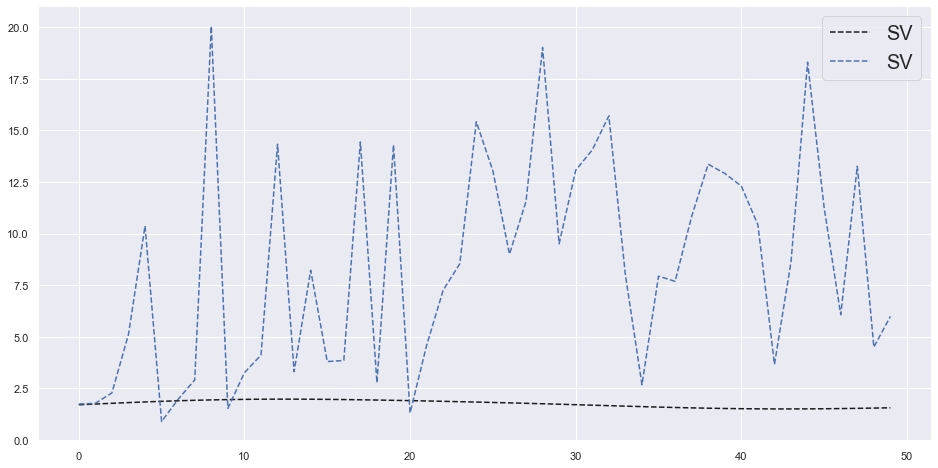

In [81]:
time=[t for t in range(num_iterations)]
plt.plot(sv_energies,'k--',label="SV")
plt.plot(sv_energies2,'b--',label="SV")
plt.legend(prop={'size': 20})